In [9]:
#importing libraries
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

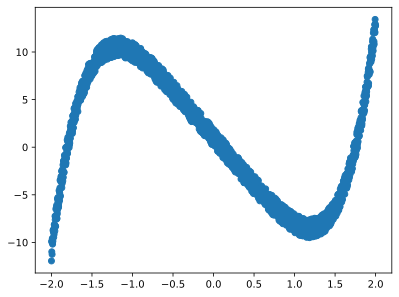

torch.Size([2000, 1])


In [11]:
#creating dataset
x = torch.linspace(-2, 2, 2000) #500-sample dataset
y = x.pow(5) - 10 * x.pow(1) + 2*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1) #forms a 1d tensor from the dataset, for better manipulation by pytorch
y = torch.unsqueeze(y, dim=1)
# x, y = x.to(device), y.to(device)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()


f = lambda x: x.pow(5) - 10 * x.pow(1) + 2*torch.rand(x.size())
print(f(x).shape)


In [12]:
def clean_target(x):
    return x.pow(5) - 10 * x.pow(1)+1


def target(x):
    return x.pow(5) - 10 * x.pow(1) + 2*torch.rand(x.size())


In [13]:
#creating 10 models, ranging between 100 and 1000 neurones per model - I'm going to test how accurate each one is
models = [nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                    in_features=1, out_features=i),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                    in_features=i, out_features=i),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0.9, prior_sigma=0.1,
                    in_features=i, out_features=1),
).to(device) for i in range(500, 1100, 100)]


In [14]:
mse_loss = nn.MSELoss() #mean standard error - indicates model's accuracy
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False) #kullback-leibler divergence - indicates model's uncertainty
kl_weight = 0.01 #indicates importance of kl-divergence wrt mse_loss

optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models] #optimisers for models - good idea to learn more of this later, but this is now engrained in them

In [ ]:
mse_losses = []
kl_divs = []

for i in range(len(models)): # testing effect of no. of neurones on mse
    for step in range(2000):  # 2000 epochs
        pre = models[i](x.to(device)).to(device)  # generates predictions of y from x through the bnn
        mse = mse_loss(pre, y.to(device)).to(device)
        kl = kl_loss(models[i].to(device)).to(device)
        cost = mse + kl_weight*kl

        optimizers[i].zero_grad()  # resets optimiser parameters for next epoch
        cost.backward()  # computes cost function gradients wrt to model's parameters (weights, biases, etc)
        optimizers[i].step()  # updates model parameters - this is the learning part of the model

    mse_losses.append(mse.item())
    kl_divs.append(kl.item())
    print(f'-Model[{i}] MSE : {mse.item():2.2f}, KL : {kl.item():2.2f}')

# print(len(mse_losses))
lowest_mse_model = models[kl_divs.index(min(kl_divs))]
lowest_mse_optimizer = optimizers[kl_divs.index(min(kl_divs))] #takes model with lowest kl_divergence

In [ ]:
no_of_epochs = [i for i in range(1000, 3500, 1000)] # testing effect of epochs on the optimal model
mse_losses = []
kl_divergences = []

final_models = []

for epochs in no_of_epochs:
    for step in range(epochs): 
        pre = lowest_mse_model(x.to(device))  
        mse = mse_loss(pre, y.to(device))
        kl = kl_loss(lowest_mse_model)
        cost = mse + kl_weight*kl

        lowest_mse_optimizer.zero_grad()  
        cost.backward()  
        lowest_mse_optimizer.step()

    final_models.append(lowest_mse_model)
    mse_losses.append(mse.item())
    kl_divergences.append(kl.item())
    print(f'-With {epochs} epochs, MSE : {mse.item():2.2f}, KL : {kl.item():2.2f}')

# print(len(final_models), len(kl_divergences))
final_model = final_models[kl_divergences.index(min(kl_divergences))].to(device) #takes model with lowest mse


-With 1000 epochs, MSE : 0.62, KL : 0.35
-With 2000 epochs, MSE : 0.48, KL : 0.40
-With 3000 epochs, MSE : 0.59, KL : 0.50


In [ ]:
#creating test data
x_test = torch.linspace(-2, 2, 1000)
y_test = target(x_test)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

print(y_test.shape)
from scipy.signal import savgol_filter

torch.Size([1000, 1])


In [ ]:
models_result = np.array([final_model(x_test.to(device)).cpu().data.numpy() for k in range(10000)]) #10,000 element array - each element is a 3d numpy array (evaluations, data points, predictions)
print(models_result.shape)
models_result = models_result[:,:,0] #elements are now 2d arrays (evaluations, data points)
print(models_result.shape)
models_result = models_result.T #(data points, evaluations) - y vs x
print(models_result.shape)

mean_values = np.array([models_result[i].mean() for i in range(len(models_result))]) #computes mean evaluations for each element in models_result
mean_values = savgol_filter(mean_values, window_length=991, polyorder=5)
std_values = np.array([models_result[i].std() for i in range(len(models_result))]) #computes std of each mean in mean_values

print(np.mean(mean_values), len(mean_values))
print(np.mean(std_values))

#* these variable names are really bad...

(10000, 1000, 1)
(10000, 1000)
(1000, 10000)
0.94019765 1000
0.17787665


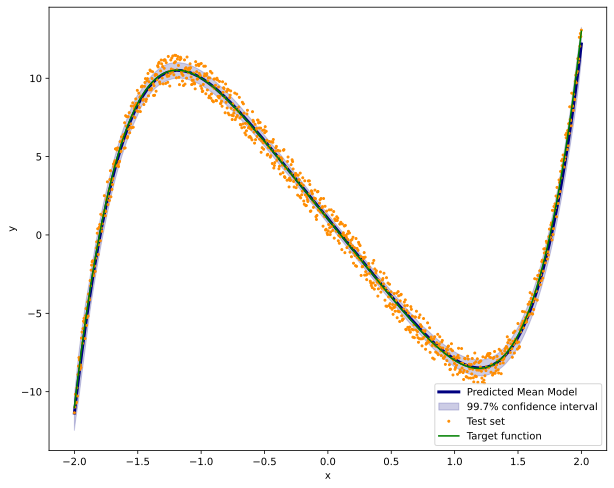

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(x_test.data.cpu().numpy(), mean_values, color='navy',
         lw=3, label='Predicted Mean Model')
plt.fill_between(x_test.data.cpu().numpy().T[0], mean_values-3.0*std_values, mean_values +
                 3.0*std_values, alpha=0.2, color='navy', label='99.7% confidence interval')
plt.plot(x_test.data.numpy(), y_test.data.numpy(), '.',
         color='darkorange', markersize=4, label='Test set')
plt.plot(x_test.data.cpu().numpy(), clean_target(x_test).cpu().data.numpy(),
         color='green', markersize=4, label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.savefig("bnn.pdf")

In [ ]:
df = pd.DataFrame(
    {'x': x_test.data.cpu().numpy().T[0], 'mean': mean_values, 'std': std_values}
)
df

NameError: name 'x_test' is not defined